In [152]:
import brian2 as b2
import numpy as np
import matplotlib.pyplot as plt
from brian2 import TimedArray, ms
import sys 
sys.path.append('C:/Users/Nishant Joshi/Downloads/Old_code/repo/single_cell_analysis/scripts')
from utils import *


In [ ]:


def reorder_x(x, ordervecs):
	# % Reorder the vectors in orderdervec (nvec x length) to x=1 (up) and x=0 (down). 
	x = np.array(x,dtype=np.int32)
	[nov, Nt] = np.shape(ordervecs)

	xt1 = np.concatenate((x[slice(0,1),slice(0,1)],x),axis=1) #np.concatenate((x[slice(0,1),slice(0,1)],x),axis=1)
	xt2 = np.concatenate((x,x[slice(0,1),slice(-2,-1)]),axis=1) #np.concatenate((x,x[slice(0,1),slice(-2,-1)]),axis=1) 
	xj = xt2-xt1 #% this is equal to xj(n) = x(n)-x(n-1)

	njumpup = np.size(np.where(xj==1)[0])

	njumpdown = np.size(np.where(xj==-1)[0])

	# reorder 
	if njumpup > 0 and njumpdown>0:
		print('here 5.5.5.5.5')
		firstjump = np.where(np.abs(xj)==1)[1]
		firstjump = firstjump[0]
		revecsup = np.nan*np.ones((nov,njumpup+1 ,round(10*Nt/njumpup)))		 
		revecsdown = np.nan*np.ones((nov,njumpdown+1 ,round(10*Nt/njumpdown)))
		[_, _, size3] = np.shape(revecsdown)

		if x[0,firstjump] == 1:
			up = 1 
			down  = 0
			revecsup[:,1,1] = ordervecs[:,firstjump]
		elif x[0,firstjump]==0:
			up = 0
			down = 1
			revecsdown[:,1,1] = ordervecs[:,firstjump]
		else: 
			raise('first jump not properly defined')
		tt = 1
		tmaxup = 1
		tmaxdown = 1
		for nn in range(firstjump+1, Nt):
			try:
				jump = int(x[0,nn]-x[0,nn-1])
			except:
				print('size ordervecs not the same as size x!')
				exit()
			if jump ==0:
				tt = tt+1
				if x[0,nn] == 1:
					# up state 
					if tt>tmaxup:
						tmaxup = tt
					revecsup[:,up,tt] = ordervecs[:,nn]
				elif x[0,nn] == 0:
					#down state 
					if tt >tmaxdown:
						tmaxdown = tt
					revecsdown[:,down,tt] =ordervecs[:,nn]
	
				else:
					raise('something went wrong: x not 0 or 1')
			elif jump ==1:
				# jump up 
				tt = 1 
				up = up+1
				if x[0,nn] == 1:
					revecsup[:,up,tt] = ordervecs[:,nn]
				else:
					raise('something went wrong: jump up but x is not 1')
			elif jump == -1:
				# % jump down
				tt = 1
				down = down+1
				if x[0,nn]==0:
					revecsdown[:,down,tt] = ordervecs[:,nn]

				else:
					raise('something went wrong: jump down but x is not 0')
						
			else: 
				raise('something went wrong: no jump up or down')
			if tt>size3-1:
				# % tt will run out of matrix size
				raise('choose larger starting matrix')
	else:
		if njumpup<1:
			print('no jumps up; reordering not possible')
			revecsup = np.NaN
			revecsdown = np.NaN	
	print('revecsup ',np.nansum(revecsup))				
	return revecsup, revecsdown


def calc_MI_ideal(ron, roff, spiketrain, x, dt):
	# Calculate the mutual information between hidden state x and output spike
	# train (same size vector) assuming a ideal observer that knows ron and roff
	# NB Note that if dt in ms, then ron and roff in kHz
	# NB Note that information is calculated in bits. For nats use log instead
	# of log2
	
	# Functions 
	def dLdt(L, ron, roff, input, w, theta):

		y = ron*(1+np.exp(-L))-roff*(1+np.exp(L)) + w*input - theta
		return y 
	def sig(x):
		y = 1/(1+np.exp(-x))
		return y 

	def MIEst(L,x):
		Hxx = - (np.mean(x)*np.log2(np.mean(x))) -( (1-np.mean(x))*np.log2(1-np.mean(x)))
		Hxy = - np.mean(x*np.log2(sig(L))+(1-x)*np.log2(1-sig(L)))
		MI =  Hxx - Hxy
		return Hxx, Hxy, MI
	print('spiketrain ',np.nansum(spiketrain))
	#  Calculate qon and qoff -> w and theta
	[spikesup, spikesdown] = reorder_x(x, spiketrain)
	print('spikesup ',np.nansum(spikesup))
	spikesup = np.squeeze(spikesup)
	spikesdown = np.squeeze(spikesdown)

	nspikesup = np.nansum(spikesup)
	qon = nspikesup/(sum(x)*dt)
	nspikesdown = np.nansum(np.nansum(spikesdown))
	if nspikesdown == 0:
		nspikesdown = 1
	
	qoff = nspikesdown/((np.size(x) - sum(x))*dt)
	w = np.log(qon/qoff)
	theta = qon-qoff

	# Integrate L
	input = np.squeeze(spiketrain/dt)
	L = np.NAN*np.ones(np.size(x))
	L[0] = np.log(ron/roff)
	for nn in range(np.size(x)-1):
		L[nn+1] = L[nn]+dLdt(L[nn], ron, roff, input[nn], w, theta)*dt
		if abs(L[nn+1])>1000:
			print('L diverges, weigths too large')
			break
	
	# Calculate MI
	[Hxx, Hxy, MI] = MIEst(L,x)
	

	return Hxx, Hxy, MI, L, qon, qoff


def calc_MI_input(ron, roff, input, theta, x, dt ):
	# Calculate the mutual information between hidden state x and generated
	# input train (same size vector) assuming a ideal observer that knows ron
	# and roff and theta.
	# NB Note that if dt in ms, then ron and roff in kHz
	# NB Note that information is calculated in bits. For nats use log instead
	# of log2

	# Functions 

	def dLdt(L, ron, roff, input, theta):
		y = ron*(1+np.exp(-L))-roff*(1+np.exp(L)) + input - theta
		return y
	def MIEst(L,x):
		Hxx = - np.mean(x)*np.log2(np.mean(x)) - (1-np.mean(x))*np.log2(1-np.mean(x))
		Hxy = - np.mean(x*np.log2(sig(L))+(1-x)*np.log2(1-sig(L)))
		MI =  Hxx - Hxy		
		return  Hxx, Hxy, MI
	def sig(x):
		print('x sdhape ',x.shape)
		y = 1./(1+np.exp(-x))
		return y 

	# Integrate L
	L = np.NaN*np.ones(np.shape(x))
	L[0] = np.log(ron/roff)
	for nn in range(len(x) -1 ):
		L[nn+1] = L[nn] +dLdt(L[nn], ron, roff, input[nn], theta)*dt
		if abs(L[nn+1]) > 1000:
			print('L diverges, weigths too large')
			break
	
	# Calculate MI
	[Hxx, Hxy, MI] = MIEst(L,x)
	return [Hxx, Hxy, MI, L]



In [153]:




# def OU_test(mu, sigma, dt, tau, unit, total_t,seed):
#     np.random.seed(seed)
#     time = np.arange(0, total_t, dt)
#     x = np.zeros((len(time), 1))
#     x[0, 0] = 0
#     for i in range(1, len(time)):
#         x[i, 0] =mu+ ((x[i - 1, 0] - mu) * np.exp(-dt / tau)) + sigma * np.sqrt(1 - np.exp(-2 * dt / tau)) * np.random.normal()
#     return x*unit


def my_OU(pars, mu, sig, myseed=False):
  """
  Function that produces Ornstein-Uhlenbeck input

  Args:
    pars       : parameter dictionary
    sig        : noise amplitute
    myseed     : random seed. int or boolean

  Returns:
    I_ou       : Ornstein-Uhlenbeck input current
  """

  # Retrieve simulation parameters
  dt, range_t = pars['dt'], pars['range_t']
  Lt = range_t.size
  tau_ou = pars['tau_ou']  # [ms]

  # set random seed
  if myseed:
    np.random.seed(seed=myseed)
  else:
    np.random.seed()

  # Initialize
  noise = np.random.randn(Lt)
  I_ou = np.zeros(Lt)
  I_ou[0] = noise[0] * sig

  # generate OU
  for it in range(Lt-1):
    I_ou[it+1] = I_ou[it] + (dt / tau_ou) * (mu - I_ou[it]) + np.sqrt(2 * dt / tau_ou) * sig * noise[it + 1]

  return I_ou



def run_LIF(pars,Iinj, stop=False):
    V_th, V_reset = pars['V_th'], pars['V_reset']
    tau_m, g_L = pars['tau_m'], pars['g_L']
    V_init, E_L = pars['V_init'], pars['E_L']
    dt, range_t = pars['dt'], pars['range_t']
    T = pars['T']
    seed = pars['seed']
    Lt = range_t.size
    tref = pars['tref']
    v = np.zeros(Lt)
    v[0] = V_init


    rec_spikes = []
    tr = 0.

    for it in range(Lt - 1):
        if tr > 0:
            v[it] = V_reset
            tr = tr - 1

        elif v[it] >= V_th:
            rec_spikes.append(it)
            v[it] = V_reset
            tr = tref / dt

        dv = (-(v[it] - E_L) + Iinj[it] / g_L) * (dt / tau_m)
        v[it + 1] = v[it] + dv
        rec_spikes_ = np.array(rec_spikes) * dt

    return v, rec_spikes_, Iinj



default_pars = {
    'V_th': 0.0279, 'V_reset': -0.0279, 'tau_m': 10.0,
    'tau_ou':10,'g_L': 1., 'V_init': 0, 'E_L': 0.0, 
    'tref': 2.0, 'T': 1000.0, 'dt': 0.1, 'seed': 0
}

default_pars['range_t'] = np.arange(default_pars['T']/default_pars['dt'])



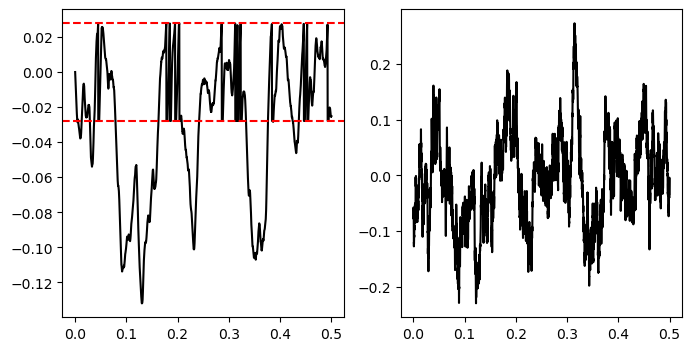

26.0


In [154]:

default_pars['T'] = 500
default_pars['dt'] = 0.1

default_pars['range_t'] = np.arange(default_pars['T']/default_pars['dt'])

spikes_t_s_u = []
spikes_t_s_r = []
N_stim = 1
fig,ax = plt.subplots(1,2,figsize=[8,4])

SNR = 0.6
st = my_OU(default_pars, 0,0.1, myseed=0)
nt = my_OU(default_pars, 0,0.1, )
Iinj = SNR * st + np.sqrt(1 - SNR) * nt
# If current pulse, set beginning and end to 0
# Iinj = np.ones((int(default_pars['T']/default_pars['dt'])))*1000
# Iinj[:int(len(Iinj) / 2) - 1000] = 0
# Iinj[int(len(Iinj) / 2) + 1000:] = 0

# for i in range(N_stim):
default_pars['seed'] = 1
v, spikes, I = run_LIF(default_pars,Iinj)
spikes_t_s_u.append(spikes)


ax[0].plot(np.arange(0,0.5,0.0001),v,c='black')
ax[0].axhline(y=default_pars['V_th'],linestyle='--',c='red')
ax[0].axhline(y=default_pars['V_reset'],linestyle='--',c='red')

# ax[0].scatter(np.array(spikes / 0.1 - 0.01, dtype=np.int32), v[np.array(spikes / 0.1 - 0.01, dtype=np.int32)])
ax[1].plot(np.arange(0,0.5,0.0001),I,c='black')
plt.show()
print(len(spikes)/0.5)

In [156]:
data = loadmatInPy("D:/Analyzed/asli_5-8-19_E3_analyzed.mat")

{'V_th': 0.0279, 'V_reset': -0.0279, 'tau_m': 10.0, 'tau_ou': 10, 'g_L': 1.0, 'V_init': 0, 'E_L': 0.0, 'tref': 2.0, 'T': 1000, 'dt': 0.05, 'seed': 1, 'range_t': array([0.0000e+00, 1.0000e+00, 2.0000e+00, ..., 1.9997e+04, 1.9998e+04,
       1.9999e+04])}
firing rate 5.0


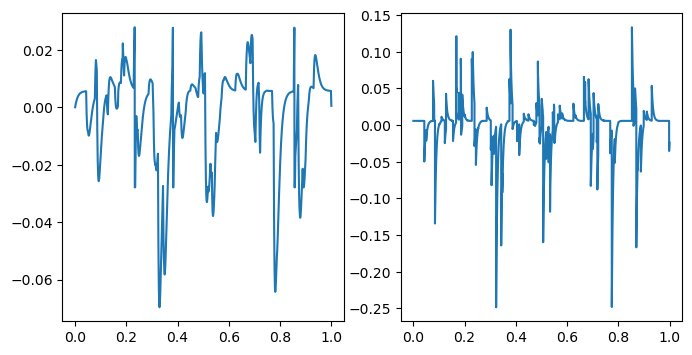

In [160]:
fig,ax = plt.subplots(1,2,figsize=[8,4])

Iinj = data[0]['input_current']
default_pars['dt'] =1/20
default_pars['T'] =1000
default_pars['range_t'] = np.arange(default_pars['T']/default_pars['dt'])
input_scale = 3000
print(default_pars)
v, spikes, I = run_LIF(default_pars,Iinj[:1000*20]/input_scale)
spikes_t_s_u.append(spikes)
# plt.plot(v)
print('firing rate',len(spikes_t_s_u)/(default_pars['T']/1000))
ax[0].plot(np.arange(0,1,1/20000),v)
ax[1].plot(np.arange(0,1,1/20000),I)
plt.show()
